In [1]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-PCA.ipynb


import os
import seaborn as sns
import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

from sklearn import preprocessing
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.


In [3]:
path = 'E:\stim_code_epochs'
epoch_files = os.listdir(path)

In [4]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

51


In [5]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[2]), preload = True)

Reading E:\stim_code_epochs\20140205_1230_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
978 matching events found
Applying baseline correction (mode: mean)
978 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [ ]:
epoch.events[900:]

In [ ]:
493165 * 1/512

In [ ]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [6]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-6-20254dd9ff05>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage);


In [7]:
evoked = epoch.average();

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-10-3c2ac81ef012>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  evoked.plot_topomap(size = 2);


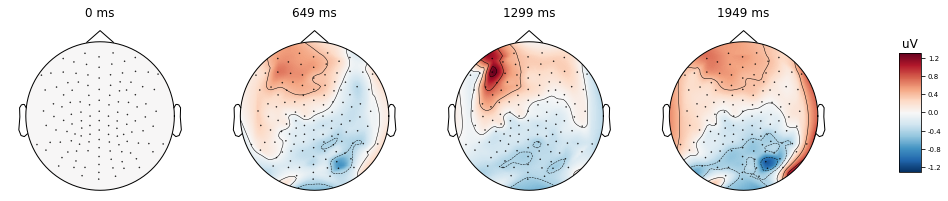

In [10]:
evoked.plot_topomap(size = 2);

In [ ]:
epoch.plot_sensors(show_names=True);

In [ ]:
data = epoch.get_data()

In [ ]:
new_events = convert_epoch_events_to_stim_combinations(epoch)
print(new_events.shape)

In [ ]:
epoch.events = new_events

In [ ]:
# create arrays based on audio and visual
audio_epochs = []
visual_epochs = []

for i in range(len(epoch)): 
#     print(i)
    if epoch[i].events[:,-1][0] <700:
#         print("audio")
        audio_epochs.append(epoch[i].get_data())
    else:
#         print("visual")
        visual_epochs.append(epoch[i].get_data())

In [ ]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())
scaled_audio_data = pipeline.fit_transform(audio_epochs)
scaled_visual_data = pipeline.fit_transform(visual_epochs)

In [ ]:
vectorizer = make_pipeline(Vectorizer())
vectorized_audio_data = vectorizer.fit_transform(audio_epochs)
vectorized_visual_data = vectorizer.fit_transform(visual_epochs)


In [ ]:
scaled_audio_data = preprocessing.scale(vectorized_audio_data)
scaled_visual_data = preprocessing.scale(vectorized_visual_data)

In [ ]:
audio_variance = []
for data in scaled_audio_data:
#     print(data)
    audio_variance.append(np.var(data))
visual_variance = []
for data in scaled_visual_data:
    visual_variance.append(np.var(data))

In [ ]:
all_variance = []


In [ ]:
np.array(audio_variance).shape

In [ ]:
def get_audio_visual_labels(epoch_object):
    events = epoch_object.events[:,-1]
    labels = []
    for event in events:
        if event < 700:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels) 

### extracting frequency bands

In [ ]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch


In [ ]:
gamma_epoch = get_frequency_band('Gamma', epoch)
theta_epoch = get_frequency_band('Theta', epoch)
beta_epoch = get_frequency_band('Beta', epoch)
alpha_epoch = get_frequency_band('Alpha',epoch)

In [ ]:
def variance_of_epochs(epoch_object):
    pipeline = make_pipeline(Vectorizer(), StandardScaler())
    
    scaled_epoch_data = pipeline.fit_transform(epoch_object.get_data())
    
    variance_epochs = []
    for data in scaled_epoch_data:
        variance_epochs.append(np.var(data))
    
    return np.array(variance_epochs)

In [ ]:
def mean_of_epochs(epoch_object):
    pipeline = make_pipeline(Vectorizer(), StandardScaler())
    
    scaled_epoch_data = pipeline.fit_transform(epoch_object.get_data())
    
    mean_epochs = []
    for data in scaled_epoch_data:
        mean_epochs.append(np.mean(data))
    
    return np.array(mean_epochs)

In [ ]:
variance_gamma_epochs = variance_of_epochs(gamma_epoch)
variance_theta_epochs = variance_of_epochs(theta_epoch)
variance_beta_epochs = variance_of_epochs(beta_epoch)
variance_alpha_epochs = variance_of_epochs(alpha_epoch)

In [ ]:
variance_gamma_epochs = variance_gamma_epochs[:-1]
variance_theta_epochs = variance_theta_epochs[:-1]
variance_beta_epochs = variance_beta_epochs[:-1]
variance_alpha_epochs = variance_alpha_epochs[:-1]

In [ ]:
variance_gamma_epochs.shape

In [ ]:
labels = get_audio_visual_labels(gamma_epoch)

In [ ]:
alpha_epoch.events.shape

In [ ]:
epoch.events.shape

In [ ]:
print(variance_alpha_epochs.shape)
print(labels.shape)

In [ ]:
plt.scatter(variance_gamma_epochs[labels == 0], 
            variance_theta_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_gamma_epochs[labels == 1], 
            variance_theta_epochs[labels == 1], c = 'blue', marker = 'o');


In [ ]:
plt.scatter(variance_beta_epochs[labels == 0], 
            variance_alpha_epochs[labels == 0], c = 'red', marker = 'x');
plt.scatter(variance_beta_epochs[labels == 1], 
            variance_alpha_epochs[labels == 1], c = 'blue', marker = 'o');
plt.scatter(variance_gamma_epochs[labels == 0], 
            variance_theta_epochs[labels == 0], c = 'k', marker = 's');
plt.scatter(variance_gamma_epochs[labels == 1], 
            variance_theta_epochs[labels == 1], c = 'green', marker = '_');


In [ ]:
epoch.plot_psd_topomap(ch_type='eeg');

In [ ]:
epoch.plot_psd_topomap(ch_type='eeg');

In [ ]:
epoch.plot_image();

## Isolating Channels of visual and Audio Channels 
* After isolating these channels I will classify.

In [ ]:
visual_channels = ['RC7','RD7','RE4','R12','R13','RR12','RR13',
                   'LC7','LD7',';LE4','L12','L13','LL12','LL13']
audio_channels = [x for x in epoch.ch_names if 'LD' in x or 'LC' in x or 'LA' in x
                  or 'RD' in x or 'RC' in x or 'RA' in x]

In [ ]:
bad_channels = []
for ch in epoch.ch_names:
    if ch not in visual_channels and ch not in audio_channels:
        bad_channels.append(ch)

In [ ]:
epoch.drop_channels(ch_names= bad_channels)

In [ ]:
epoch.get_data().shape

In [ ]:
gamma_epoch = get_frequency_band('Gamma', epoch)

In [ ]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())

In [ ]:
mean_stats = get_mean_band(gamma_epoch[:-1])
mean_stats = mean_stats.swapaxes(1,2)

In [ ]:
audio_visual_events = []
for event in new_events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [ ]:
epoch.events = new_events

# Classification Pipeline

In [ ]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

In [ ]:
test_epoch = mne.read_epochs(os.path.join(path, epoch_files[6]), preload = True)

In [ ]:
test_events = convert_epoch_events_to_stim_combinations(test_epoch)

In [ ]:
test_epoch_gamma = get_frequency_band('Gamma', test_epoch)
test_epoch_gamma = test_epoch_gamma[:-1]

In [ ]:
test_epoch_gamma.get_data().shape

In [ ]:
for event in test_events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [ ]:
test_events.shape

In [ ]:
vect_scale = make_pipeline(Vectorizer(),
                    StandardScaler())
scaled_test_epoch_gamma_data = vect_scale.fit_transform(test_epoch_gamma)

In [ ]:
clf.score(scaled_test_epoch_gamma_data, test_events[:,-1])

In [ ]:
cm3 = confusion_matrix(labels, preds)
cm3_normalized = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm3_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Audio vs. Visual with Audio and Visual Related Channels', size = 20)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, size = 20)
plt.yticks(tick_marks, target_names,size = 20)
tight_layout()
plt.ylabel('True label',size = 20)
plt.xlabel('Predicted label',size = 20)
plt.show()

In [ ]:
new_events.shape

In [ ]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(mean_stats))
for train, test in cv.split(mean_stats, labels):
    start = time.time()
    clf.fit(mean_stats[train], labels[train])
    preds[test] = clf.predict(mean_stats[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))